In [1]:
import gc
import os
import operator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import xgbfir

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix, hstack

In [2]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}

categorical_features = [
# 'ip',
# 'app',
# 'device',
# 'os',
# 'channel',
]


numerical_features = [
    'PERCENT_TRUE(clicks.is_attributed)_app_7days',
    'PERCENT_TRUE(clicks.is_attributed)_device_7days',
    'PERCENT_TRUE(clicks.is_attributed)_os_7days',
    'PERCENT_TRUE(clicks.is_attributed)_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_ip_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_device_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_os_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_device_os_7days',
    'PERCENT_TRUE(clicks.is_attributed)_device_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_os_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_device_os_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_device_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_app_os_channel_7days',
    'PERCENT_TRUE(clicks.is_attributed)_device_os_channel_7days',

    'AVG_TIME_BETWEEN(clicks.click_time)_app_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_device_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_device_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_ip_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_ip_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_device_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_device_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_device_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_device_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_device_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_device_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_os_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_os_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_device_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_device_os_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_device_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_device_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_app_os_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_app_os_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time)_device_os_channel_7days',
    'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_device_os_channel_7days',
    
    'COUNT(clicks)_app_7days',
    'COUNT(clicks)_device_7days',
    'COUNT(clicks)_os_7days',
    'COUNT(clicks)_channel_7days',
    'COUNT(clicks)_ip_7days',
    'COUNT(clicks)_app_device_7days',
    'COUNT(clicks)_app_os_7days',
    'COUNT(clicks)_app_channel_7days',
    'COUNT(clicks)_device_os_7days',
    'COUNT(clicks)_device_channel_7days',
    'COUNT(clicks)_os_channel_7days',
    'COUNT(clicks)_app_device_os_7days',
    'COUNT(clicks)_app_device_channel_7days',
    'COUNT(clicks)_app_os_channel_7days',
    'COUNT(clicks)_device_os_channel_7days',

]

In [3]:
cache_train = '../data/cache/train_lgbm_2017-11-08.hdf.compress'
df_train = pd.read_hdf(cache_train)

cache_val = '../data/cache/validate_lgbm_2017-11-09.hdf.compress'
df_val = pd.read_hdf(cache_val)

In [10]:
def sparse_dummies(df, column):
    """Returns sparse OHE matrix for the column of the dataframe"""
    categories = Categorical(df[column])
    column_names = np.array([f"{column}_{str(i)}" for i in range(len(categories.categories))])
    N = len(categories)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix((ones, (row_numbers, categories.codes))), column_names

In [8]:
matrices = []
all_column_names = []
# creates a matrix per categorical feature
for c in categorical_features:
    matrix, column_names = sparse_dummies(df_train, c)
    matrices.append(matrix)
    all_column_names.append(column_names)
    df_train.drop(columns=[c], inplace=True)
    gc.collect()

# appends a matrix for numerical features (one column per feature)
matrices.append(csr_matrix(df_train[numerical_features].values, dtype=float))
all_column_names.append(df_train[numerical_features].columns.values)

df_train.drop(columns=numerical_features, inplace=True)
gc.collect()

train_sparse = hstack(matrices, format="csr")
feature_names = np.concatenate(all_column_names)
del matrices, all_column_names

X = train_sparse
y = df_train['is_attributed']

del df_train
gc.collect()

18

In [9]:
# Create binary training and validation files for XGBoost
x1, y1 = X[:train_size], y.iloc[:train_size]
dm1 = xgb.DMatrix(x1, y1, feature_names=feature_names)
dm1.save_binary('../data/cache/train.bin')
del dm1, x1, y1
gc.collect()

x2, y2 = X[train_size:], y.iloc[train_size:]
dm2 = xgb.DMatrix(x2, y2, feature_names=feature_names)
dm2.save_binary('../data/cache/validate.bin')
del dm2, x2, y2, X, y
gc.collect()

41

In [14]:
# XGBoost parameters example
params = {
    'alpha': 3.0,
    'colsample_bytree': 0.6,
    'eta': 0.1,
    'gamma': 2.0,
    'lambda': 1.2,
    'max_depth': 9,
    'min_child_weight': 21.0,
    'subsample': 0.6,
    'n_estimators': 500,
    'scale_pos_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'nthread': 36,
    'silent': 1
}

In [15]:
dmtrain = xgb.DMatrix('../data/cache/train.bin', feature_names=feature_names)
dmvalid = xgb.DMatrix('../data/cache/validate.bin', feature_names=feature_names)

In [16]:
watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
model = xgb.train(params, dmtrain, 500, watchlist, maximize=True, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.955664	valid-auc:0.896258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.959029	valid-auc:0.945521
[2]	train-auc:0.960689	valid-auc:0.945364
[3]	train-auc:0.961356	valid-auc:0.94541
[4]	train-auc:0.961814	valid-auc:0.945953
[5]	train-auc:0.962337	valid-auc:0.946824
[6]	train-auc:0.962743	valid-auc:0.947802
[7]	train-auc:0.962873	valid-auc:0.948739
[8]	train-auc:0.963052	valid-auc:0.948319
[9]	train-auc:0.963416	valid-auc:0.948702
[10]	train-auc:0.963598	valid-auc:0.948553
[11]	train-auc:0.9637	valid-auc:0.948844
[12]	train-auc:0.963871	valid-auc:0.948923
[13]	train-auc:0.964086	valid-auc:0.948858
[14]	train-auc:0.964191	valid-auc:0.948999
[15]	train-auc:0.96427	valid-auc:0.949165
[16]	train-auc:0.964486	valid-auc:0.949299
[17]	train-auc:0.964624	valid-auc:0.949545
[18]	train-auc:0.964682	valid-auc:0.949668
[19]	train-auc:0.964737	valid-auc:0.949665
[20]	train-

In [18]:
def objective(params):
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
    model = xgb.train(params, dmtrain, num_round, watchlist, maximize=True, early_stopping_rounds=15, verbose_eval=5)
    auc = model.best_score
    del model
    gc.collect()
    print(f"SCORE: {auc}")
    return { 'loss': 1-auc, 'status': STATUS_OK }

space = {
    'n_estimators': 500,
    'eta': hp.quniform('eta', 0.1, 1, 0.2),
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 3),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.1),
    'gamma': hp.quniform('gamma', 0.5, 2, 0.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'alpha' : hp.quniform('alpha', 0, 20, 3),
    'lambda': hp.quniform('lambda', 1, 2, 0.2),
    'scale_pos_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'nthread': 36,
    'silent': 1
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print(best)

[0]	train-auc:0.956326	valid-auc:0.919743
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.962819	valid-auc:0.921992
[2]	train-auc:0.965427	valid-auc:0.935778
[3]	train-auc:0.966318	valid-auc:0.933935
[4]	train-auc:0.96651	valid-auc:0.917554
[5]	train-auc:0.965687	valid-auc:0.925861
[6]	train-auc:0.967081	valid-auc:0.928117
[7]	train-auc:0.967408	valid-auc:0.928613
[8]	train-auc:0.967615	valid-auc:0.928229
[9]	train-auc:0.967852	valid-auc:0.928504
[10]	train-auc:0.968162	valid-auc:0.930148
[11]	train-auc:0.968509	valid-auc:0.93044
[12]	train-auc:0.968591	valid-auc:0.930672
[13]	train-auc:0.968669	valid-auc:0.930472
[14]	train-auc:0.968737	valid-auc:0.930424
[15]	train-auc:0.968784	valid-auc:0.930256
[16]	train-auc:0.968837	valid-auc:0.930337
[17]	train-auc:0.968855	valid-auc:0.930394
Stopping. Best iteration:
[2]	train-auc:0.965427	valid-auc:0.935778

SCORE: 0.935778
[0]	train-

[4]	train-auc:0.963105	valid-auc:0.939421
[5]	train-auc:0.964515	valid-auc:0.940958
[6]	train-auc:0.96503	valid-auc:0.940965
[7]	train-auc:0.965472	valid-auc:0.940962
[8]	train-auc:0.965785	valid-auc:0.941275
[9]	train-auc:0.966225	valid-auc:0.939708
[10]	train-auc:0.966561	valid-auc:0.939579
[11]	train-auc:0.966718	valid-auc:0.940066
[12]	train-auc:0.96688	valid-auc:0.940179
[13]	train-auc:0.966967	valid-auc:0.940272
[14]	train-auc:0.967093	valid-auc:0.940425
[15]	train-auc:0.967167	valid-auc:0.940501
[16]	train-auc:0.96724	valid-auc:0.940399
[17]	train-auc:0.967301	valid-auc:0.940138
[18]	train-auc:0.967386	valid-auc:0.940201
[19]	train-auc:0.96748	valid-auc:0.940384
[20]	train-auc:0.967653	valid-auc:0.940633
[21]	train-auc:0.967738	valid-auc:0.940637
[22]	train-auc:0.967804	valid-auc:0.940489
[23]	train-auc:0.968004	valid-auc:0.940692
Stopping. Best iteration:
[8]	train-auc:0.965785	valid-auc:0.941275

SCORE: 0.941275
[0]	train-auc:0.946221	valid-auc:0.931736
Multiple eval metrics h

[33]	train-auc:0.96536	valid-auc:0.942897
[34]	train-auc:0.965368	valid-auc:0.942899
[35]	train-auc:0.965458	valid-auc:0.942532
[36]	train-auc:0.965574	valid-auc:0.942456
[37]	train-auc:0.965628	valid-auc:0.942353
[38]	train-auc:0.965659	valid-auc:0.942379
[39]	train-auc:0.965665	valid-auc:0.942395
[40]	train-auc:0.965723	valid-auc:0.942357
[41]	train-auc:0.965746	valid-auc:0.942459
[42]	train-auc:0.965769	valid-auc:0.942484
[43]	train-auc:0.9658	valid-auc:0.942515
[44]	train-auc:0.965948	valid-auc:0.942585
[45]	train-auc:0.965991	valid-auc:0.942382
[46]	train-auc:0.966018	valid-auc:0.942334
[47]	train-auc:0.966075	valid-auc:0.942383
[48]	train-auc:0.966095	valid-auc:0.942393
[49]	train-auc:0.966131	valid-auc:0.942439
Stopping. Best iteration:
[34]	train-auc:0.965368	valid-auc:0.942899

SCORE: 0.942899
[0]	train-auc:0.952798	valid-auc:0.931471
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[

[141]	train-auc:0.966618	valid-auc:0.946075
[142]	train-auc:0.966633	valid-auc:0.945958
[143]	train-auc:0.966641	valid-auc:0.945932
[144]	train-auc:0.966646	valid-auc:0.945892
[145]	train-auc:0.966662	valid-auc:0.945859
[146]	train-auc:0.966663	valid-auc:0.94586
[147]	train-auc:0.966669	valid-auc:0.945866
[148]	train-auc:0.966663	valid-auc:0.94588
[149]	train-auc:0.966674	valid-auc:0.945924
[150]	train-auc:0.966685	valid-auc:0.945854
[151]	train-auc:0.966692	valid-auc:0.945869
[152]	train-auc:0.966698	valid-auc:0.945874
Stopping. Best iteration:
[137]	train-auc:0.966589	valid-auc:0.946107

SCORE: 0.946107
[0]	train-auc:0.939274	valid-auc:0.923737
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.94557	valid-auc:0.90882
[2]	train-auc:0.954069	valid-auc:0.916118
[3]	train-auc:0.955849	valid-auc:0.916918
[4]	train-auc:0.956685	valid-auc:0.916708
[5]	train-auc:0.957502	valid-auc:0.9

[48]	train-auc:0.966192	valid-auc:0.944757
[49]	train-auc:0.966305	valid-auc:0.944625
[50]	train-auc:0.966327	valid-auc:0.944744
[51]	train-auc:0.966342	valid-auc:0.944733
[52]	train-auc:0.966343	valid-auc:0.944824
[53]	train-auc:0.966366	valid-auc:0.944693
[54]	train-auc:0.966411	valid-auc:0.944632
[55]	train-auc:0.966503	valid-auc:0.944869
[56]	train-auc:0.966543	valid-auc:0.94481
[57]	train-auc:0.966556	valid-auc:0.944816
[58]	train-auc:0.966586	valid-auc:0.944934
[59]	train-auc:0.966672	valid-auc:0.944559
[60]	train-auc:0.966687	valid-auc:0.944523
[61]	train-auc:0.966694	valid-auc:0.944517
[62]	train-auc:0.966701	valid-auc:0.944496
[63]	train-auc:0.966765	valid-auc:0.944558
[64]	train-auc:0.966821	valid-auc:0.944419
[65]	train-auc:0.966913	valid-auc:0.944661
[66]	train-auc:0.966939	valid-auc:0.944553
[67]	train-auc:0.966937	valid-auc:0.944544
[68]	train-auc:0.966942	valid-auc:0.944539
[69]	train-auc:0.966959	valid-auc:0.944529
[70]	train-auc:0.966966	valid-auc:0.944564
[71]	train-a

[54]	train-auc:0.967373	valid-auc:0.945751
[55]	train-auc:0.967393	valid-auc:0.945709
[56]	train-auc:0.967445	valid-auc:0.945633
[57]	train-auc:0.967466	valid-auc:0.945632
[58]	train-auc:0.967483	valid-auc:0.945633
[59]	train-auc:0.967522	valid-auc:0.945671
[60]	train-auc:0.967542	valid-auc:0.945684
[61]	train-auc:0.967564	valid-auc:0.945683
[62]	train-auc:0.96759	valid-auc:0.945699
[63]	train-auc:0.967603	valid-auc:0.945675
[64]	train-auc:0.967635	valid-auc:0.945719
[65]	train-auc:0.967652	valid-auc:0.945796
[66]	train-auc:0.967655	valid-auc:0.945791
[67]	train-auc:0.967686	valid-auc:0.945832
[68]	train-auc:0.967698	valid-auc:0.945858
[69]	train-auc:0.96771	valid-auc:0.94586
[70]	train-auc:0.967756	valid-auc:0.945842
[71]	train-auc:0.96782	valid-auc:0.945945
[72]	train-auc:0.967875	valid-auc:0.945957
[73]	train-auc:0.967913	valid-auc:0.945948
[74]	train-auc:0.967918	valid-auc:0.945959
[75]	train-auc:0.967934	valid-auc:0.945979
[76]	train-auc:0.967976	valid-auc:0.946067
[77]	train-auc:

[41]	train-auc:0.966083	valid-auc:0.944007
[42]	train-auc:0.966096	valid-auc:0.944153
[43]	train-auc:0.966117	valid-auc:0.944126
Stopping. Best iteration:
[28]	train-auc:0.965122	valid-auc:0.944215

SCORE: 0.944215
[0]	train-auc:0.910595	valid-auc:0.881014
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.923579	valid-auc:0.889122
[2]	train-auc:0.944453	valid-auc:0.914522
[3]	train-auc:0.94578	valid-auc:0.916259
[4]	train-auc:0.946269	valid-auc:0.916459
[5]	train-auc:0.947354	valid-auc:0.917022
[6]	train-auc:0.952782	valid-auc:0.933432
[7]	train-auc:0.95287	valid-auc:0.933593
[8]	train-auc:0.953134	valid-auc:0.933722
[9]	train-auc:0.953118	valid-auc:0.933722
[10]	train-auc:0.955495	valid-auc:0.935663
[11]	train-auc:0.955555	valid-auc:0.935672
[12]	train-auc:0.95753	valid-auc:0.936856
[13]	train-auc:0.958017	valid-auc:0.936674
[14]	train-auc:0.958198	valid-auc:0.937886
[15]	train

[8]	train-auc:0.969653	valid-auc:0.943722
[9]	train-auc:0.969947	valid-auc:0.943681
[10]	train-auc:0.970119	valid-auc:0.943809
[11]	train-auc:0.970218	valid-auc:0.942296
[12]	train-auc:0.970311	valid-auc:0.942228
[13]	train-auc:0.970394	valid-auc:0.942202
[14]	train-auc:0.970476	valid-auc:0.942302
[15]	train-auc:0.970529	valid-auc:0.942306
[16]	train-auc:0.970621	valid-auc:0.942253
[17]	train-auc:0.970731	valid-auc:0.942246
[18]	train-auc:0.970763	valid-auc:0.942192
[19]	train-auc:0.970779	valid-auc:0.942293
[20]	train-auc:0.970882	valid-auc:0.942002
[21]	train-auc:0.970953	valid-auc:0.940691
Stopping. Best iteration:
[6]	train-auc:0.969259	valid-auc:0.94382

SCORE: 0.94382
[0]	train-auc:0.942941	valid-auc:0.92569
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.950119	valid-auc:0.932481
[2]	train-auc:0.955174	valid-auc:0.937444
[3]	train-auc:0.958054	valid-auc:0.939119
[4]	tra

[19]	train-auc:0.966475	valid-auc:0.942844
[20]	train-auc:0.966541	valid-auc:0.94287
[21]	train-auc:0.966683	valid-auc:0.943095
[22]	train-auc:0.966723	valid-auc:0.943132
[23]	train-auc:0.966776	valid-auc:0.943512
[24]	train-auc:0.966909	valid-auc:0.9436
[25]	train-auc:0.966966	valid-auc:0.943601
[26]	train-auc:0.967018	valid-auc:0.943534
[27]	train-auc:0.967242	valid-auc:0.943205
[28]	train-auc:0.967297	valid-auc:0.943276
[29]	train-auc:0.967362	valid-auc:0.943757
[30]	train-auc:0.967434	valid-auc:0.943747
[31]	train-auc:0.967466	valid-auc:0.943648
[32]	train-auc:0.967529	valid-auc:0.943659
[33]	train-auc:0.967592	valid-auc:0.943408
[34]	train-auc:0.967632	valid-auc:0.943703
[35]	train-auc:0.967641	valid-auc:0.94365
[36]	train-auc:0.967721	valid-auc:0.943218
[37]	train-auc:0.967754	valid-auc:0.943216
[38]	train-auc:0.967889	valid-auc:0.943428
[39]	train-auc:0.967917	valid-auc:0.943336
[40]	train-auc:0.967935	valid-auc:0.943378
[41]	train-auc:0.967979	valid-auc:0.942979
[42]	train-auc:

[10]	train-auc:0.95387	valid-auc:0.935807
[11]	train-auc:0.955309	valid-auc:0.937457
[12]	train-auc:0.956964	valid-auc:0.936319
[13]	train-auc:0.957577	valid-auc:0.936016
[14]	train-auc:0.9583	valid-auc:0.93675
[15]	train-auc:0.95878	valid-auc:0.936567
[16]	train-auc:0.958851	valid-auc:0.936644
[17]	train-auc:0.958812	valid-auc:0.936534
[18]	train-auc:0.959152	valid-auc:0.936617
[19]	train-auc:0.959613	valid-auc:0.937174
[20]	train-auc:0.959805	valid-auc:0.937437
[21]	train-auc:0.960128	valid-auc:0.937885
[22]	train-auc:0.960367	valid-auc:0.938305
[23]	train-auc:0.960408	valid-auc:0.938411
[24]	train-auc:0.960512	valid-auc:0.937829
[25]	train-auc:0.960622	valid-auc:0.937605
[26]	train-auc:0.960784	valid-auc:0.937605
[27]	train-auc:0.960875	valid-auc:0.937778
[28]	train-auc:0.961079	valid-auc:0.937778
[29]	train-auc:0.961047	valid-auc:0.937786
[30]	train-auc:0.961406	valid-auc:0.938213
[31]	train-auc:0.961471	valid-auc:0.938216
[32]	train-auc:0.961499	valid-auc:0.93832
[33]	train-auc:0.

[1]	train-auc:0.957003	valid-auc:0.938484
[2]	train-auc:0.95978	valid-auc:0.941061
[3]	train-auc:0.961519	valid-auc:0.941072
[4]	train-auc:0.963077	valid-auc:0.942223
[5]	train-auc:0.963989	valid-auc:0.943369
[6]	train-auc:0.964945	valid-auc:0.943812
[7]	train-auc:0.965273	valid-auc:0.945439
[8]	train-auc:0.965426	valid-auc:0.944789
[9]	train-auc:0.965729	valid-auc:0.945726
[10]	train-auc:0.966108	valid-auc:0.945712
[11]	train-auc:0.966193	valid-auc:0.945935
[12]	train-auc:0.966701	valid-auc:0.945817
[13]	train-auc:0.96705	valid-auc:0.945301
[14]	train-auc:0.967183	valid-auc:0.945219
[15]	train-auc:0.967326	valid-auc:0.944912
[16]	train-auc:0.967464	valid-auc:0.944754
[17]	train-auc:0.967621	valid-auc:0.945139
[18]	train-auc:0.967683	valid-auc:0.945373
[19]	train-auc:0.967796	valid-auc:0.944759
[20]	train-auc:0.967918	valid-auc:0.944917
[21]	train-auc:0.968062	valid-auc:0.945115
[22]	train-auc:0.968108	valid-auc:0.94464
[23]	train-auc:0.968176	valid-auc:0.944743
[24]	train-auc:0.968231

[26]	train-auc:0.970559	valid-auc:0.94312
[27]	train-auc:0.970583	valid-auc:0.943125
[28]	train-auc:0.97062	valid-auc:0.943168
[29]	train-auc:0.970632	valid-auc:0.943028
[30]	train-auc:0.970649	valid-auc:0.94303
[31]	train-auc:0.970671	valid-auc:0.943027
[32]	train-auc:0.97069	valid-auc:0.942948
[33]	train-auc:0.970741	valid-auc:0.942917
[34]	train-auc:0.97075	valid-auc:0.942871
[35]	train-auc:0.970781	valid-auc:0.942904
[36]	train-auc:0.970803	valid-auc:0.942904
[37]	train-auc:0.970833	valid-auc:0.942741
Stopping. Best iteration:
[22]	train-auc:0.970259	valid-auc:0.943864

SCORE: 0.943864
[0]	train-auc:0.964518	valid-auc:0.933082
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.966286	valid-auc:0.931046
[2]	train-auc:0.968109	valid-auc:0.939018
[3]	train-auc:0.969046	valid-auc:0.940585
[4]	train-auc:0.969449	valid-auc:0.940789
[5]	train-auc:0.969842	valid-auc:0.941614
[6]	trai

[13]	train-auc:0.969068	valid-auc:0.942171
[14]	train-auc:0.96915	valid-auc:0.942192
[15]	train-auc:0.969192	valid-auc:0.942219
[16]	train-auc:0.969299	valid-auc:0.942386
[17]	train-auc:0.969376	valid-auc:0.942478
[18]	train-auc:0.969446	valid-auc:0.942665
[19]	train-auc:0.969547	valid-auc:0.942967
[20]	train-auc:0.969646	valid-auc:0.942785
[21]	train-auc:0.969762	valid-auc:0.942878
[22]	train-auc:0.969799	valid-auc:0.942955
[23]	train-auc:0.969848	valid-auc:0.94286
[24]	train-auc:0.969919	valid-auc:0.942807
[25]	train-auc:0.969967	valid-auc:0.942725
[26]	train-auc:0.969994	valid-auc:0.942716
[27]	train-auc:0.970059	valid-auc:0.942688
[28]	train-auc:0.970103	valid-auc:0.942656
[29]	train-auc:0.970132	valid-auc:0.942364
[30]	train-auc:0.970169	valid-auc:0.942347
[31]	train-auc:0.970206	valid-auc:0.942334
[32]	train-auc:0.970303	valid-auc:0.942269
[33]	train-auc:0.970366	valid-auc:0.942519
[34]	train-auc:0.970418	valid-auc:0.94257
Stopping. Best iteration:
[19]	train-auc:0.969547	valid-a

[47]	train-auc:0.963332	valid-auc:0.942738
[48]	train-auc:0.963322	valid-auc:0.94286
[49]	train-auc:0.963331	valid-auc:0.94286
[50]	train-auc:0.963379	valid-auc:0.942957
[51]	train-auc:0.963385	valid-auc:0.942977
[52]	train-auc:0.963409	valid-auc:0.942958
[53]	train-auc:0.96343	valid-auc:0.943158
[54]	train-auc:0.963492	valid-auc:0.943223
[55]	train-auc:0.963496	valid-auc:0.943226
[56]	train-auc:0.963586	valid-auc:0.94322
[57]	train-auc:0.963589	valid-auc:0.94322
[58]	train-auc:0.963616	valid-auc:0.943393
[59]	train-auc:0.963627	valid-auc:0.943389
[60]	train-auc:0.963642	valid-auc:0.94341
[61]	train-auc:0.963673	valid-auc:0.943411
[62]	train-auc:0.963695	valid-auc:0.943494
[63]	train-auc:0.963733	valid-auc:0.943496
[64]	train-auc:0.963735	valid-auc:0.943578
[65]	train-auc:0.963729	valid-auc:0.943511
[66]	train-auc:0.963749	valid-auc:0.943649
[67]	train-auc:0.96389	valid-auc:0.943655
[68]	train-auc:0.963912	valid-auc:0.943535
[69]	train-auc:0.963901	valid-auc:0.943534
[70]	train-auc:0.9

[17]	train-auc:0.965878	valid-auc:0.94142
[18]	train-auc:0.965995	valid-auc:0.941783
[19]	train-auc:0.966046	valid-auc:0.941894
[20]	train-auc:0.966135	valid-auc:0.942306
[21]	train-auc:0.96638	valid-auc:0.942811
[22]	train-auc:0.966506	valid-auc:0.942617
[23]	train-auc:0.966561	valid-auc:0.942643
[24]	train-auc:0.966645	valid-auc:0.942763
[25]	train-auc:0.966667	valid-auc:0.94285
[26]	train-auc:0.966711	valid-auc:0.94278
[27]	train-auc:0.96689	valid-auc:0.942939
[28]	train-auc:0.966929	valid-auc:0.942988
[29]	train-auc:0.966958	valid-auc:0.942919
[30]	train-auc:0.967023	valid-auc:0.942943
[31]	train-auc:0.967076	valid-auc:0.942675
[32]	train-auc:0.96715	valid-auc:0.942476
[33]	train-auc:0.96722	valid-auc:0.942229
[34]	train-auc:0.967359	valid-auc:0.942499
[35]	train-auc:0.967371	valid-auc:0.942601
[36]	train-auc:0.967435	valid-auc:0.942587
[37]	train-auc:0.967462	valid-auc:0.942597
[38]	train-auc:0.967569	valid-auc:0.942563
[39]	train-auc:0.9676	valid-auc:0.942456
[40]	train-auc:0.967

[21]	train-auc:0.97034	valid-auc:0.945146
[22]	train-auc:0.970376	valid-auc:0.94514
[23]	train-auc:0.970422	valid-auc:0.944665
[24]	train-auc:0.970464	valid-auc:0.944612
[25]	train-auc:0.970511	valid-auc:0.944769
[26]	train-auc:0.970564	valid-auc:0.944832
[27]	train-auc:0.970591	valid-auc:0.944323
[28]	train-auc:0.970624	valid-auc:0.944543
[29]	train-auc:0.970653	valid-auc:0.944554
[30]	train-auc:0.97067	valid-auc:0.944689
[31]	train-auc:0.970696	valid-auc:0.944449
[32]	train-auc:0.970724	valid-auc:0.944523
[33]	train-auc:0.970752	valid-auc:0.944509
[34]	train-auc:0.970767	valid-auc:0.944546
Stopping. Best iteration:
[19]	train-auc:0.970193	valid-auc:0.945334

SCORE: 0.945334
[0]	train-auc:0.961556	valid-auc:0.919245
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.963366	valid-auc:0.927736
[2]	train-auc:0.966515	valid-auc:0.942522
[3]	train-auc:0.967489	valid-auc:0.94373
[4]	t

[18]	train-auc:0.969844	valid-auc:0.947376
[19]	train-auc:0.969911	valid-auc:0.947185
[20]	train-auc:0.969961	valid-auc:0.946387
[21]	train-auc:0.970005	valid-auc:0.946196
[22]	train-auc:0.970042	valid-auc:0.946181
[23]	train-auc:0.970084	valid-auc:0.946119
[24]	train-auc:0.970128	valid-auc:0.946202
[25]	train-auc:0.970177	valid-auc:0.946304
[26]	train-auc:0.970226	valid-auc:0.946336
[27]	train-auc:0.97024	valid-auc:0.946345
[28]	train-auc:0.97025	valid-auc:0.94649
Stopping. Best iteration:
[13]	train-auc:0.969486	valid-auc:0.947584

SCORE: 0.947584
[0]	train-auc:0.960686	valid-auc:0.93345
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.960694	valid-auc:0.927838
[2]	train-auc:0.965823	valid-auc:0.937026
[3]	train-auc:0.96639	valid-auc:0.939363
[4]	train-auc:0.967162	valid-auc:0.941696
[5]	train-auc:0.967763	valid-auc:0.942406
[6]	train-auc:0.967802	valid-auc:0.942354
[7]	train

[0]	train-auc:0.953593	valid-auc:0.932999
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.95592	valid-auc:0.931928
[2]	train-auc:0.961846	valid-auc:0.936517
[3]	train-auc:0.963335	valid-auc:0.940511
[4]	train-auc:0.964998	valid-auc:0.942223
[5]	train-auc:0.965424	valid-auc:0.943616
[6]	train-auc:0.966434	valid-auc:0.943223
[7]	train-auc:0.966853	valid-auc:0.944404
[8]	train-auc:0.967175	valid-auc:0.944239
[9]	train-auc:0.967372	valid-auc:0.943939
[10]	train-auc:0.967572	valid-auc:0.943955
[11]	train-auc:0.967833	valid-auc:0.944194
[12]	train-auc:0.967982	valid-auc:0.944321
[13]	train-auc:0.968078	valid-auc:0.944414
[14]	train-auc:0.968149	valid-auc:0.943243
[15]	train-auc:0.968249	valid-auc:0.943241
[16]	train-auc:0.968493	valid-auc:0.943404
[17]	train-auc:0.968673	valid-auc:0.94364
[18]	train-auc:0.968731	valid-auc:0.943675
[19]	train-auc:0.968775	valid-auc:0.943711
[20]	trai

[18]	train-auc:0.953953	valid-auc:0.935758
[19]	train-auc:0.954084	valid-auc:0.935948
[20]	train-auc:0.95408	valid-auc:0.935965
[21]	train-auc:0.954069	valid-auc:0.93596
[22]	train-auc:0.955484	valid-auc:0.937577
[23]	train-auc:0.956903	valid-auc:0.937775
[24]	train-auc:0.957765	valid-auc:0.938021
[25]	train-auc:0.957889	valid-auc:0.938212
[26]	train-auc:0.958228	valid-auc:0.938111
[27]	train-auc:0.958464	valid-auc:0.938292
[28]	train-auc:0.958756	valid-auc:0.938564
[29]	train-auc:0.958761	valid-auc:0.938556
[30]	train-auc:0.958875	valid-auc:0.938864
[31]	train-auc:0.959151	valid-auc:0.938638
[32]	train-auc:0.95964	valid-auc:0.938638
[33]	train-auc:0.959809	valid-auc:0.939023
[34]	train-auc:0.959824	valid-auc:0.939064
[35]	train-auc:0.959609	valid-auc:0.939164
[36]	train-auc:0.959696	valid-auc:0.939344
[37]	train-auc:0.959878	valid-auc:0.9397
[38]	train-auc:0.960026	valid-auc:0.939487
[39]	train-auc:0.960187	valid-auc:0.939667
[40]	train-auc:0.960253	valid-auc:0.939543
[41]	train-auc:0

[207]	train-auc:0.963875	valid-auc:0.942583
[208]	train-auc:0.963879	valid-auc:0.942489
[209]	train-auc:0.963877	valid-auc:0.94248
[210]	train-auc:0.963881	valid-auc:0.94248
[211]	train-auc:0.963898	valid-auc:0.942453
[212]	train-auc:0.963894	valid-auc:0.94248
[213]	train-auc:0.963909	valid-auc:0.942437
[214]	train-auc:0.963914	valid-auc:0.942433
[215]	train-auc:0.963918	valid-auc:0.942431
[216]	train-auc:0.963921	valid-auc:0.94243
[217]	train-auc:0.963921	valid-auc:0.94237
[218]	train-auc:0.963924	valid-auc:0.942384
[219]	train-auc:0.963927	valid-auc:0.942384
[220]	train-auc:0.963929	valid-auc:0.942384
[221]	train-auc:0.963932	valid-auc:0.942374
Stopping. Best iteration:
[206]	train-auc:0.963859	valid-auc:0.942585

SCORE: 0.942585
[0]	train-auc:0.960735	valid-auc:0.935252
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.964879	valid-auc:0.93641
[2]	train-auc:0.966937	valid-auc

[104]	train-auc:0.966895	valid-auc:0.943963
[105]	train-auc:0.966935	valid-auc:0.943976
[106]	train-auc:0.966949	valid-auc:0.943976
[107]	train-auc:0.966948	valid-auc:0.943936
[108]	train-auc:0.966958	valid-auc:0.944025
[109]	train-auc:0.966968	valid-auc:0.943916
[110]	train-auc:0.966982	valid-auc:0.943994
[111]	train-auc:0.966983	valid-auc:0.943998
[112]	train-auc:0.966998	valid-auc:0.943917
[113]	train-auc:0.967009	valid-auc:0.943933
[114]	train-auc:0.967019	valid-auc:0.944
[115]	train-auc:0.967024	valid-auc:0.944019
[116]	train-auc:0.96703	valid-auc:0.944008
[117]	train-auc:0.96704	valid-auc:0.943947
Stopping. Best iteration:
[102]	train-auc:0.966861	valid-auc:0.94413

SCORE: 0.94413
[0]	train-auc:0.959585	valid-auc:0.933123
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.96455	valid-auc:0.935959
[2]	train-auc:0.966377	valid-auc:0.940593
[3]	train-auc:0.966843	valid-auc:0.9

[27]	train-auc:0.970688	valid-auc:0.945392
[28]	train-auc:0.970702	valid-auc:0.945613
Stopping. Best iteration:
[13]	train-auc:0.969874	valid-auc:0.947642

SCORE: 0.947642
[0]	train-auc:0.963543	valid-auc:0.93589
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.966651	valid-auc:0.938275
[2]	train-auc:0.967967	valid-auc:0.941185
[3]	train-auc:0.968475	valid-auc:0.942501
[4]	train-auc:0.968845	valid-auc:0.943576
[5]	train-auc:0.969319	valid-auc:0.944642
[6]	train-auc:0.969585	valid-auc:0.943502
[7]	train-auc:0.969769	valid-auc:0.943203
[8]	train-auc:0.969992	valid-auc:0.94351
[9]	train-auc:0.970165	valid-auc:0.943824
[10]	train-auc:0.97026	valid-auc:0.944402
[11]	train-auc:0.970319	valid-auc:0.944319
[12]	train-auc:0.970402	valid-auc:0.944306
[13]	train-auc:0.970468	valid-auc:0.944118
[14]	train-auc:0.970503	valid-auc:0.943957
[15]	train-auc:0.970545	valid-auc:0.943871
[16]	train

[23]	train-auc:0.970857	valid-auc:0.941973
[24]	train-auc:0.97089	valid-auc:0.942427
Stopping. Best iteration:
[9]	train-auc:0.969889	valid-auc:0.94378

SCORE: 0.94378
[0]	train-auc:0.955205	valid-auc:0.93185
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[1]	train-auc:0.957736	valid-auc:0.933092
[2]	train-auc:0.960614	valid-auc:0.937923
[3]	train-auc:0.963226	valid-auc:0.94143
[4]	train-auc:0.965065	valid-auc:0.942779
[5]	train-auc:0.965321	valid-auc:0.945058
[6]	train-auc:0.965944	valid-auc:0.944935
[7]	train-auc:0.966296	valid-auc:0.945973
[8]	train-auc:0.966702	valid-auc:0.946156
[9]	train-auc:0.966868	valid-auc:0.94615
[10]	train-auc:0.96714	valid-auc:0.946248
[11]	train-auc:0.967429	valid-auc:0.946629
[12]	train-auc:0.967495	valid-auc:0.9473
[13]	train-auc:0.967772	valid-auc:0.94693
[14]	train-auc:0.967902	valid-auc:0.947163
[15]	train-auc:0.968134	valid-auc:0.946994
[16]	train-auc:0.9

[6]	train-auc:0.936012	valid-auc:0.928218
[7]	train-auc:0.946417	valid-auc:0.927896
[8]	train-auc:0.946469	valid-auc:0.928664
[9]	train-auc:0.946864	valid-auc:0.929362
[10]	train-auc:0.951911	valid-auc:0.932263
[11]	train-auc:0.951925	valid-auc:0.932154
[12]	train-auc:0.951983	valid-auc:0.932173
[13]	train-auc:0.952804	valid-auc:0.933015
[14]	train-auc:0.952814	valid-auc:0.932779
[15]	train-auc:0.952915	valid-auc:0.934781
[16]	train-auc:0.953605	valid-auc:0.935596
[17]	train-auc:0.953933	valid-auc:0.935699
[18]	train-auc:0.953975	valid-auc:0.935761
[19]	train-auc:0.954117	valid-auc:0.93595
[20]	train-auc:0.955688	valid-auc:0.935965
[21]	train-auc:0.955649	valid-auc:0.935956
[22]	train-auc:0.956533	valid-auc:0.937593
[23]	train-auc:0.957089	valid-auc:0.937801
[24]	train-auc:0.957945	valid-auc:0.938041
[25]	train-auc:0.95808	valid-auc:0.938231
[26]	train-auc:0.958244	valid-auc:0.938125
[27]	train-auc:0.958472	valid-auc:0.93828
[28]	train-auc:0.95847	valid-auc:0.938274
[29]	train-auc:0.95

[20]	train-auc:0.959551	valid-auc:0.938846
[21]	train-auc:0.959901	valid-auc:0.939313
[22]	train-auc:0.960291	valid-auc:0.939794
[23]	train-auc:0.960756	valid-auc:0.940006
[24]	train-auc:0.960914	valid-auc:0.940093
[25]	train-auc:0.961113	valid-auc:0.940248
[26]	train-auc:0.96136	valid-auc:0.940191
[27]	train-auc:0.961563	valid-auc:0.940791
[28]	train-auc:0.96166	valid-auc:0.940982
[29]	train-auc:0.961786	valid-auc:0.941164
[30]	train-auc:0.961844	valid-auc:0.941218
[31]	train-auc:0.961994	valid-auc:0.940971
[32]	train-auc:0.96225	valid-auc:0.941111
[33]	train-auc:0.962305	valid-auc:0.941067
[34]	train-auc:0.962409	valid-auc:0.941543
[35]	train-auc:0.962454	valid-auc:0.941764
[36]	train-auc:0.962544	valid-auc:0.941764
[37]	train-auc:0.962692	valid-auc:0.941743
[38]	train-auc:0.96275	valid-auc:0.94188
[39]	train-auc:0.962827	valid-auc:0.94175
[40]	train-auc:0.962869	valid-auc:0.941772
[41]	train-auc:0.962898	valid-auc:0.941794
[42]	train-auc:0.962929	valid-auc:0.94183
[43]	train-auc:0.9

In [12]:
# Feature importance as a DataFrame
importance = sorted(model.get_fscore().items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
print(df.sort_values('fscore', ascending=False).head(10))

                                               feature    fscore
250        PERCENT_TRUE(clicks.is_attributed)_app_1day  0.095277
249    PERCENT_TRUE(clicks.is_attributed)_channel_1day  0.088762
248         PERCENT_TRUE(clicks.is_attributed)_os_1day  0.072476
247        AVG_TIME_BETWEEN(clicks.click_time)_os_1day  0.057003
246  AVG_TIME_BETWEEN(clicks.click_time WHERE is_at...  0.042345
245   AVG_TIME_BETWEEN(clicks.click_time)_channel_1day  0.025244
244   COUNT(clicks WHERE is_attributed = True)_os_1day  0.022801
243       AVG_TIME_BETWEEN(clicks.click_time)_app_1day  0.019544
242                      MODE(clicks.app)_channel_1day  0.019544
241     PERCENT_TRUE(clicks.is_attributed)_device_1day  0.017915


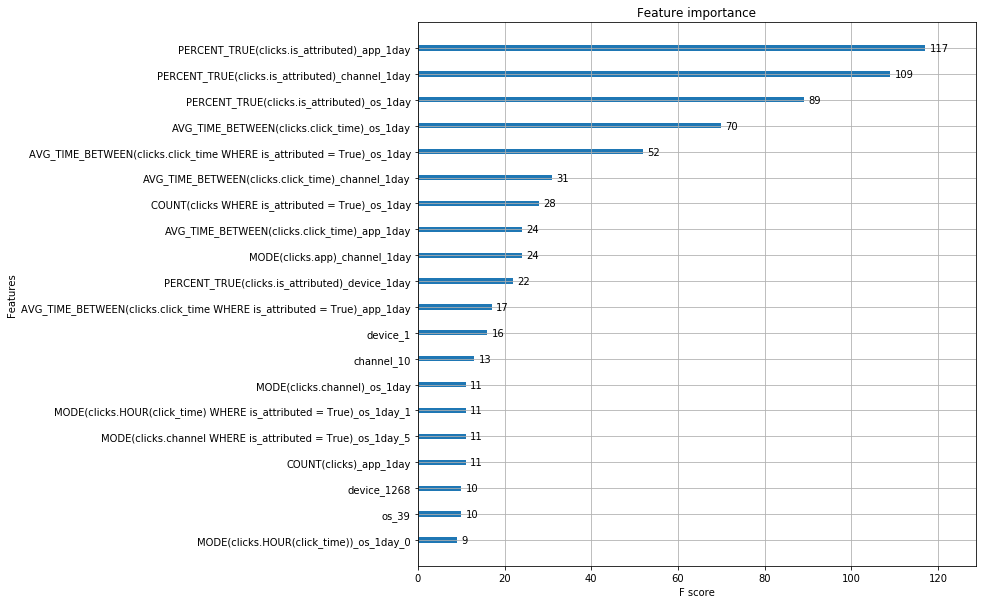

In [13]:
# Feature importance as a plot
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax, max_num_features=20)
plt.savefig('importance.png', format="png")

In [ ]:
xgbfir.saveXgbFI(model)